In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta

class WeatherDataFetcher:
    def __init__(self, latitude, longitude):
        self.latitude = latitude
        self.longitude = longitude
        self.base_url = "https://archive-api.open-meteo.com/v1/archive"

    def fetch_data(self, start_date, end_date):
        params = {
            "latitude": self.latitude,
            "longitude": self.longitude,
            "start_date": start_date,
            "end_date": end_date,
            "hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "surface_pressure", "precipitation", "cloudcover"],
            "timezone": "auto"
        }

        response = requests.get(self.base_url, params=params)

        if response.status_code == 200:
            hourly_data = response.json()["hourly"]
            df = pd.DataFrame({
                "Datetime": pd.to_datetime(hourly_data["time"]),
                "Temperature": hourly_data["temperature_2m"],
                "Humidity": hourly_data["relative_humidity_2m"],
                "Dew Point": hourly_data["dew_point_2m"],
                "Surface Pressure": hourly_data["surface_pressure"],
                "Precipitation": hourly_data["precipitation"],
                "Cloud Cover": hourly_data["cloudcover"]
            })
            return df.dropna()
        else:
            raise Exception(f"Failed to fetch data. Status code: {response.status_code}")

    def fetch_4_years_data(self):
        start_date = datetime(2020, 1, 1).date()  # Set the start date to 2020-01-01
        end_date = start_date + timedelta(days=4*365)  # Calculate the end date as 4 years later
        return self.fetch_data(start_date=start_date, end_date=end_date)

    
        # Fetch custom data based on forecast date
    def fetch_data_based_on_forecast(self, forecast_date, historical_days=35):
        """
        Fetch historical weather data ending 4 days before the forecast date.
        :param forecast_date: The target date for forecasting (in 'YYYY-MM-DD' format).
        :param historical_days: Number of days of historical data to fetch (default: 35 days).
        """
        # Convert forecast_date to datetime object
        forecast_date_obj = datetime.strptime(forecast_date, "%Y-%m-%d")
        
        # Define the range of historical data to fetch
        end_date = forecast_date_obj - timedelta(days=4)  # 4 days before the forecast date
        start_date = end_date - timedelta(days=historical_days)  # Historical days before the end date
        
        # Fetch the historical data from start_date to end_date
        return self.fetch_data(start_date=start_date.strftime('%Y-%m-%d'), end_date=end_date.strftime('%Y-%m-%d'))




In [2]:
d=WeatherDataFetcher(52.52,13.41)
f=d.fetch_data_based_on_forecast("2024-09-20")
f

,Datetime,Temperature,Humidity,Dew Point,Surface Pressure,Precipitation,Cloud Cover
0,2024-08-12 00:00:00,16.4,77,12.3,1015.8,0.0,1
1,2024-08-12 01:00:00,15.9,76,11.8,1015.6,0.0,2
2,2024-08-12 02:00:00,15.2,77,11.3,1015.3,0.0,0
3,2024-08-12 03:00:00,13.7,87,11.6,1015.0,0.0,0
4,2024-08-12 04:00:00,13.3,89,11.6,1014.5,0.0,0
...,...,...,...,...,...,...,...
859,2024-09-16 19:00:00,17.5,86,15.1,1016.4,0.0,100
860,2024-09-16 20:00:00,16.7,90,15.1,1017.0,0.0,100
861,2024-09-16 21:00:00,16.3,93,15.1,1017.2,0.0,23
862,2024-09-16 22:00:00,15.8,95,15.0,1017.4,0.0,19


In [3]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from preprocessing import DataPreprocessor
import joblib
import numpy as np
from fetching_data import WeatherDataFetcher
from preprocessing import DataPreprocessor
import datetime

            Temperature   Humidity  Dew Point  Surface Pressure  \
Datetime                                                          
2024-08-12    20.337500  61.875000  11.950000       1012.395833   
2024-08-13    22.741667  52.916667  11.612500       1009.350000   
2024-08-14    25.554167  47.166667  12.929167       1007.366667   
2024-08-15    23.750000  75.416667  18.754167       1009.845833   
2024-08-16    23.670833  67.416667  16.445833       1010.250000   
2024-08-17    23.320833  70.250000  17.162500       1007.829167   
2024-08-18    20.754167  78.166667  16.662500       1005.370833   
2024-08-19    19.562500  62.583333  11.837500       1011.766667   
2024-08-20    20.770833  63.708333  12.883333       1010.304167   
2024-08-21    20.216667  64.166667  12.483333       1006.733333   
2024-08-22    19.104167  53.333333   8.637500       1008.829167   
2024-08-23    23.062500  46.541667  10.037500       1004.604167   
2024-08-24    25.179167  58.166667  15.200000       1007.27083

In [23]:
# Load the pre-trained LSTM model and scaler
model = tf.keras.models.load_model('saved_models/model.keras')
feature_scaler = joblib.load('saved_models/feature_scaler.pkl')
temperature_scaler = joblib.load('saved_models/temperature_scaler.pkl')

In [24]:
time_steps = model.input_shape[1] 
time_steps

15

In [25]:
from fetching_data import WeatherDataFetcher
from preprocessing import DataPreprocessor
from model import ModelBuilder
import numpy as np
from sklearn.model_selection import train_test_split


In [26]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(df, fit=True):
    # Select relevant features (excluding Temperature since it's the target)
    features = df[['Humidity', 'Dew Point', 'Surface Pressure', 'Precipitation', 'Cloud Cover']]
    temperature = df[['Temperature']]

    # Two separate scalers: one for features, one for temperature
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    temperature_scaler = MinMaxScaler(feature_range=(0, 1))
    if fit:
        # Fit and transform features and temperature separately
        scaled_features = feature_scaler.fit_transform(features)
        scaled_temperature = temperature_scaler.fit_transform(temperature)
    else:
        # Just transform the new data using already fitted scalers
        scaled_features = feature_scaler.transform(features)
        scaled_temperature = temperature_scaler.transform(temperature)

    # Combine the scaled features and temperature as two separate outputs
    return scaled_features, scaled_temperature,feature_scaler,temperature_scaler

In [27]:
preprocessor = DataPreprocessor()
scaled_features, scaled_temperature,feature_scaler,temperature_scaler = preprocessor.preprocess(df)


In [31]:
# Step 1: Fetch data for the last 5 years
fetcher = WeatherDataFetcher(latitude=40.7128, longitude=-74.0060)  # Example: New York City
df = fetcher.fetch_4_years_data()
print(df)
# Step 2: Preprocess the data
preprocessor = DataPreprocessor()
scaled_features, scaled_temperature,feature_scaler,temperature_scaler= preprocessor.preprocess(df)



# Step 3: Create sequences for LSTM
time_steps = 15  # For example, using 24 time steps (24 hours)
X, y = preprocessor.create_sequences(scaled_features, scaled_temperature, time_steps)

# Step 4: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


            Temperature   Humidity  Dew Point  Surface Pressure  \
Datetime                                                          
2020-01-01     2.208333  59.916667  -5.112500       1003.620833   
2020-01-02     2.350000  71.125000  -2.583333       1009.533333   
2020-01-03     6.437500  87.666667   4.466667       1006.033333   
2020-01-04     7.625000  96.875000   7.150000       1000.137500   
2020-01-05     2.637500  61.416667  -4.416667       1005.570833   
...                 ...        ...        ...               ...   
2023-12-27     6.762500  97.250000   6.316667       1014.700000   
2023-12-28     9.808333  94.250000   8.925000       1002.079167   
2023-12-29     9.425000  82.166667   6.270833       1000.866667   
2023-12-30     5.233333  68.000000  -0.266667       1000.662500   
2023-12-31     2.679167  69.375000  -2.708333       1010.308333   

            Precipitation  Cloud Cover  
Datetime                                
2020-01-01       0.000000    46.416667  
2020-

10/10 [==============================] - 1s 9ms/step


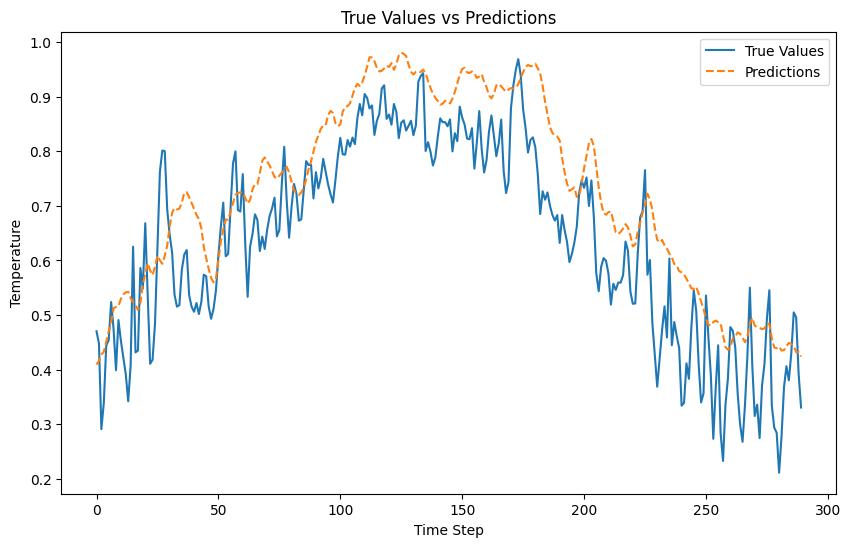

In [32]:
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 3: Plot the true values and predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Values')
plt.plot(y_pred, label='Predictions', linestyle='--')
plt.title('True Values vs Predictions')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.legend()
plt.show()


9/9 [==============================] - 0s 9ms/step


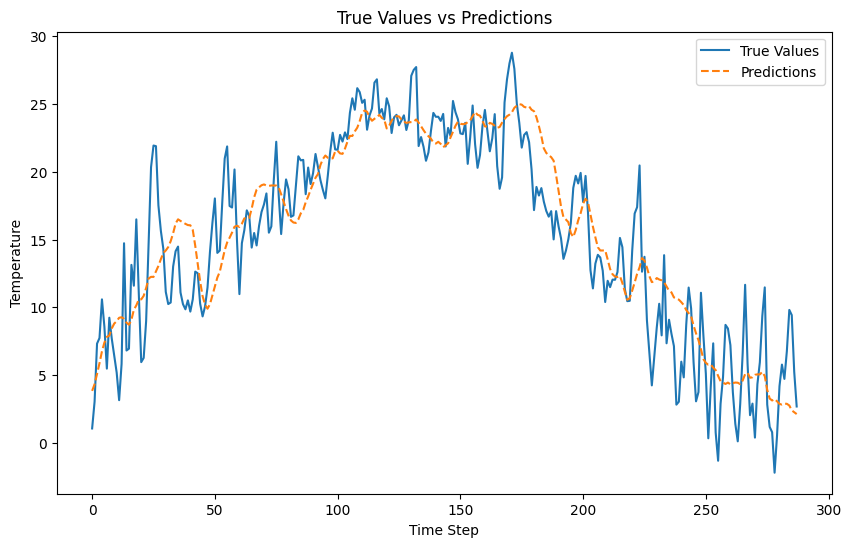

In [20]:
import matplotlib.pyplot as plt

# Step 1: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 2: Inverse transform the predictions and the true values
y_pred_inverse = temperature_scaler.inverse_transform(y_pred.reshape(-1, 1))  # Reverse scaling for predictions
y_test_inverse = temperature_scaler.inverse_transform(y_test.reshape(-1, 1))  # Reverse scaling for true values

# Step 3: Plot the true values and predictions
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='True Values')
plt.plot(y_pred_inverse, label='Predictions', linestyle='--')
plt.title('True Values vs Predictions')
plt.xlabel('Time Step')
plt.ylabel('Temperature')
plt.legend()
plt.show()
